# FRECUENCIAS (EVI)

### En este notebook se realiza un raster con la frecuencia con la que un pixel de Landsat está por encima de un valor del índice EVI. La idea es ver la distribución espacial de los blooms de algas en el embalse de Valdecañas

Lo primero que debemos hacer es recorrer todas las Landsat normalizadas que tenemos de la escena 202/32 y generar el EVI de cada una de ella.

In [ ]:
import os

path_nor = r'G:\VDCNS\protocolo\nor' 

escenasl5 = []
escenasl7 = []
escenasl8 = []

EVI = []

for e in sorted(os.listdir(path_nor)):
    
    escena = os.path.join(path_nor, e)
    
    if 'l5' in escena:
        
        bandas = []
        for i in os.listdir(escena):
            if i.endswith('b1.img'):
                bandas.append(i)
            elif i.endswith('b3.img'):
                    bandas.append(i)
            elif i.endswith('b4.img'):
                        bandas.append(i)
            else:
                continue
                
            if len(bandas) == 3:
                escenasl5.append(escena)
                EVI.append(os.path.join(path_nor, escena))

    
    if 'l7' in escena:
        
        bandas = []
        for i in os.listdir(escena):
            if i.endswith('b1.img'):
                bandas.append(i)
            elif i.endswith('b3.img'):
                    bandas.append(i)
            elif i.endswith('b4.img'):
                        bandas.append(i)
            else:
                continue
                
            if len(bandas) == 3:
                escenasl7.append(escena)
                EVI.append(os.path.join(path_nor, escena))
                
    if 'l8' in escena:
        
        bandas = []
        for i in os.listdir(escena):
            if i.endswith('b2.img'):
                bandas.append(i)
            elif i.endswith('b4.img'):
                    bandas.append(i)
            elif i.endswith('b5.img'):
                        bandas.append(i)
            else:
                continue
                
            if len(bandas) == 3:
                escenasl8.append(escena)
                EVI.append(os.path.join(path_nor, escena))

                        
                        
    
print('Se pueden analizar un total de', len(escenasl5) + len(escenasl7) + len(escenasl8), 'escenas de Landsat')              


De los 228 escenas normalizadas, se puede realizar el EVI a 198 de ellas. A las 30 restantes les falta alguna de las 3 bandas necesarias para poder aplicar la fórmula del EVI.

# <font color=red>Fórmulas del EVI:</font>

## <font color=darkblue>Landsat 4-7: EVI = 2.5 * ((b4 - b3)/(b4 + 6 * b3 - 7.5 * b1 + 1)</font>

## <font color=darkblue> Landsat 8: EVI = 2.5 * ((b5 - b4)/(b5 + 6 * b4 - 7.5 * b2 + 1)</font>

Ahora vamos a recorrer las escenas normalizadas y a generalizar el índice para posteriormente generar el raster con la frecuencia de <em>blooms</em> en cada pixel del embalse

In [ ]:
import rasterio

path_pro = r'G:\VDCNS\protocolo\pro'

for escena in EVI:
        
    if 'l8oli' in escena:
        
        print(escena)
        
        for banda in os.listdir(escena):

            try:
                
                #print('Haciendo', escena) 
                outpath = os.path.join(path_pro, os.path.split(escena)[1])
                outfilevi = os.path.join(outpath, os.path.split(escena)[1] + 'evi_.img')
                outfilendvi = os.path.join(outpath, os.path.split(escena)[1] + 'ndvi_.img')

                if banda.endswith('b2.img'):
                    b1 = os.path.join(escena, banda)
                    print(b1)
                    #with rasterio.open(b2) as srcb2:
                        #B2 = srcb2.read()
                elif banda.endswith('b4.img'):
                    b3 = os.path.join(escena, banda)
                    print(b3)

                elif banda.endswith('b5.img'):
                    b4 = os.path.join(escena, banda)
                    print(b4)
                    #with rasterio.open(b5) as srcb5:
                        #B5 = srcb5.read()

                    with rasterio.open(b1) as srcb1:
                        BLUE = srcb1.read()
                    with rasterio.open(b3) as srcb3:
                        RED = srcb3.read()
                    with rasterio.open(b4) as srcb4:
                        NIR = srcb4.read()

                    #Ahora calculamos el EVI paso a paso, por algun *** motivo, asi sale bien
                    a = NIR.astype(float) - RED.astype(float)
                    b = NIR + (6 * RED)
                    c = -7.5 * (BLUE + 1)
                    d = b -c
                    e = a / d
                    f = 2.5 * e

                    #EVIf = 2.5 * ((NIR-RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))
                    ndvi = (NIR.astype(float) - RED.astype(float)) / (NIR+RED)

                    profile = srcb3.meta
                    profile.update(dtype=rasterio.float32)

                    with rasterio.open(outfilevi, 'w', **profile) as dst:
                        dst.write(f.astype(rasterio.float32))

                    with rasterio.open(outfilendvi, 'w', **profile) as dst:
                        dst.write(ndvi.astype(rasterio.float32))

                    print('Haciendo', escena)
                            
            except Exception as e:
                print(e, escena)
                continue

### En teoría el umbral debería de ser 0, pero tras comprobar unas cuantas escenas se ha decidio dejarlo en 0.03. De todos modos, se probaran varios umbrales (0, 0.1, 0.2 y 0.3), así como la suma absoluta de los valores.

### Antes de hacer esto debemos de recortar todos los EVIs generados con la cota 318, que es la extensión con la que se generaron las máscaras de agua del embalse

In [ ]:
import os, rasterio, subprocess

path_pro = r'G:\VDCNS\protocolo\pro'

for pro in os.listdir(path_pro):
    
    escena = os.path.join(path_pro, pro)
    for i in os.listdir(escena):
        #print(escena)
        if i.endswith('evi_.img'):
            evi = os.path.join(escena, i)
            outrec = os.path.join(escena, i[:-4] + 'rec.img')
            print(outrec)
            
            cmd = ["gdalwarp", "-of", "ENVI", "-te", "287340", "4405140", "301860", "4418730", "-tr", "30", "30", "-tap","-overwrite"]
            #cmd = ["gdalwarp", "-cutline", "-crop_to_cutline", "-of", "ENVI"] #PROBAR A DEJAR EL DTM ORIGINAL -9999 A VER SI SALE MEJOR
            cmd.append(evi)
            cmd.append(outrec)
            proc = subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
            stdout,stderr=proc.communicate()
            exit_code=proc.wait()

            if exit_code: 
                raise RuntimeError(stderr)
            else:
                print(stdout)
                print('EVI generado', escena)

## <font color=red> Ahora debemos de aplicar las máscaras de agua que obtuvimos para la topografía de cada escena, y hacer una máscara binaria, donde todo el agua cuyo valor sea superior al umbral señalado como <em>bloom</em> será 1 y el resto 0. De este modo, podremos hacer las sumas de todas las máscaras y ver la frecuencia en la que ha hábido presencia de algas en un pixel </font>

In [1]:
import os, rasterio, subprocess

path_pro = r'G:\VDCNS\protocolo\pro'

for pro in os.listdir(path_pro):
    
    escena = os.path.join(path_pro, pro)
    
    for i in os.listdir(escena):
        
        try:
            
            if i.endswith('evi_rec.img'):
                evi = os.path.join(escena, i)

            elif i.endswith('water_reclass_3.img'):
                watermask = os.path.join(escena, i)


                #print(watermask,'\n', evi)
                #Ya tenemos la variables en cada escena, ahora hacemos la reclasificación para que lo que no sea agua valga 0, y 
                #no alterar la suma metiendo valores altos de pastizales que pudiera haber en las orillas

                with rasterio.open(evi) as src_evi:
                    EVIREC = src_evi.read()
                with rasterio.open(watermask) as src_msk:
                    WATER = src_msk.read()

                EVIREC[WATER != 1] = 0

                outfile = os.path.join(escena, os.path.split(escena)[1] + '_evi_reclass.img')

                profile = src_evi.meta
                #profile.update(dtype=rasterio.float32)

                with rasterio.open(outfile, 'w', **profile) as dst:
                    dst.write(EVIREC.astype(rasterio.float32))
                
                print(escena, 'realizada')
                
        except Exception as e:
            print(escena, e)
            continue

G:\VDCNS\protocolo\pro\19840910l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19840926l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19850305l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19850812l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19860612l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19860628l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870412l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870530l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870701l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870802l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870903l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19890612l4tm202_32 realizada
G:\VDCNS\protocolo\pro\19890815l4tm202_32 realizada
G:\VDCNS\protocolo\pro\19900810l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19910517l4tm202_32 realizada
G:\VDCNS\protocolo\pro\19990827l7etm202_32 realizada
G:\VDCNS\protocolo\pro\19991201l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20000219l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20000610l7etm202_32 realizada
G:\VDCNS

G:\VDCNS\protocolo\pro\20140617l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20140625l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20140711l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20140727l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20140804l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20140812l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20140820l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20140905l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20140913l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20141023l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20141031l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20141202l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20141226l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20150103l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20150111l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20150119l8oli202_32 realizada
G:\VDCNS\protocolo\pro\20150127l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20150212l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20150308l8oli202_32 rea

## <font color=Orange>Ya tenemos las máscaras del EVI sólo para las zonas de agua (siendo el resto valor 0 para poder hacer la suma). Ahora vamos a hacer las reclasificaciones de los umbrales (0. 0.01, 0.02 y 0.03) para hacer las sumas de lo que se puede considerar un <em>Bloom</em></font>

In [1]:
import os, rasterio, subprocess
import numpy as np

path_pro = r'G:\VDCNS\protocolo\pro'

for pro in os.listdir(path_pro):
       
    escena = os.path.join(path_pro, pro)

    if os.path.isdir(escena):

        for i in os.listdir(escena):

            try:

                if i.endswith('_evi_reclass.img'):
                    evi = os.path.join(escena, i)


                    #print(watermask,'\n', evi)
                    #Ya tenemos la variables en cada escena, ahora hacemos la reclasificación para que lo que no sea agua valga 0, y 
                    #no alterar la suma metiendo valores altos de pastizales que pudiera haber en las orillas

                    with rasterio.open(evi) as src_evi:
                        EVIREC = src_evi.read()

                    #Ahora mismo hacemos un reclassify entre lo que es agua y lo que no, para poder calcualr después frecuencias
                    EVIRECLASS = np.where(EVIREC != 0, 1, 0)

                    outfile = os.path.join(escena, os.path.split(escena)[1] + '_binwaterB.img')

                    profile = src_evi.meta
                    #profile.update(dtype=rasterio.float32)

                    with rasterio.open(outfile, 'w', **profile) as dst:
                        dst.write(EVIRECLASS.astype(rasterio.float32))

                    print(escena, 'realizada')

            except Exception as e:
                print(escena, e)
                continue


G:\VDCNS\protocolo\pro\19840910l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19840926l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19850305l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19850812l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19860612l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19860628l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870412l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870530l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870701l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870802l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19870903l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19890612l4tm202_32 realizada
G:\VDCNS\protocolo\pro\19890815l4tm202_32 realizada
G:\VDCNS\protocolo\pro\19900810l5tm202_32 realizada
G:\VDCNS\protocolo\pro\19910517l4tm202_32 realizada
G:\VDCNS\protocolo\pro\19990827l7etm202_32 realizada
G:\VDCNS\protocolo\pro\19991201l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20000219l7etm202_32 realizada
G:\VDCNS\protocolo\pro\20000525l7etm202_32 realizada
G:\VDCNS

ValueError: invalid literal for int() with base 10: 'evi_'

## <font color=#DF013A>Tenemos las sumas de los <em>blooms</em> y el número de veces que un pixel está inundado, por tanto ya podemos normalizar el número de <em>blooms</em> por la cantidad de días que el pixel ha estado inundado.

In [3]:
import os, rasterio, subprocess

evi = r'G:\VDCNS\protocolo\pro\suma_evi1_2007a.TIF'
waterbin = r'G:\VDCNS\protocolo\pro\suma_waterbin_2007a.TIF'

try:

    with rasterio.open(evi) as src_evi:
        EVIREC = src_evi.read()
    with rasterio.open(waterbin) as src_msk:
        WATER = src_msk.read()

    FRECUENCY = (EVIREC / WATER) * 100

    outfile = r'G:\VDCNS\protocolo\pro\evi_1_frecuencyA.img'

    profile = src_evi.meta
    #profile.update(dtype=rasterio.float32)

    with rasterio.open(outfile, 'w', **profile) as dst:
        dst.write(FRECUENCY.astype(rasterio.float32))

    print('realizado')

except Exception as e:
    print(e)

realizado


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set(color_codes=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(EVI,EVIDEPTH)
slope, intercept, r_value, p_value, std_err

(0.081614971438525974,
 306.94211706691448,
 0.57684657220056779,
 0.0,
 0.0012094669245206113)

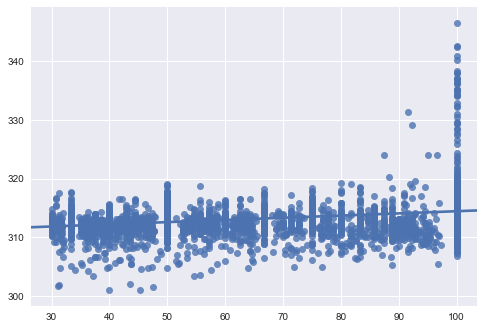

In [32]:
sns.regplot(EVI, EVIDEPTH);

In [31]:
evifreAfter = r'G:\VDCNS\protocolo\pro\evi_1_frecuencyA.img'
evifreBefore = r'G:\VDCNS\protocolo\pro\evi_1_frecuencyB.img'
waterdepth = r'G:\VDCNS\Curvas_MTN_Historico\mdt_comp1.tif'

with rasterio.open(evifreAfter) as src_evi:
    EVIAFTER = src_evi.read()
    
with rasterio.open(waterdepth) as src_msk:
    DEPTH = src_msk.read()
   
    
EVI = EVIAFTER[(EVIAFTER>30) & (DEPTH>0)]
EVIDEPTH = DEPTH[(EVIAFTER>30) & (DEPTH>0)]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in greater


In [ ]:
import os, subprocess

evi = r'G:\VDCNS\protocolo\pro\20161004l8oli202_32\20161004l8oli202_32evi_.img'
outrec = r'G:\VDCNS\protocolo\pro\20161004l8oli202_32\20161004l8oli202_32evi_rec.img'

cmd = ["gdalwarp", "-of", "ENVI", "-te", "287340", "4405140", "301860", "4418730", "-tr", "30", "30", "-tap","-overwrite"]

cmd.append(evi)
cmd.append(outrec)
proc = subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
stdout,stderr=proc.communicate()
exit_code=proc.wait()

if exit_code: 
    raise RuntimeError(stderr)
else:
    print(stdout)
    print('EVI generado', escena)import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
escena = r'G:\VDCNS\protocolo\pro\20161004l8oli202_32'


for i in os.listdir(escena):
        
    if i.endswith('evi_rec.img'):
        evi = os.path.join(escena, i)
       
    elif i.endswith('water_reclass_3.img'):
        watermask = os.path.join(escena, i)
    
    
    #print(watermask,'\n', evi)
    #Ya tenemos la variables en cada escena, ahora hacemos la reclasificación para que lo que no sea agua valga 0, y 
    #no alterar la suma metiendo valores altos de pastizales que pudiera haber en las orillas

    with rasterio.open(evi) as src_evi:
        EVIREC = src_evi.read()
    with rasterio.open(watermask) as src_msk:
        WATER = src_msk.read()
        
    EVIREC[WATER != 1] = 0
    
    outfile = r'G:\VDCNS\protocolo\pro\20161004l8oli202_32\evi_reclass.img'
    
    profile = src_evi.meta
    #profile.update(dtype=rasterio.float32)

    with rasterio.open(outfile, 'w', **profile) as dst:
        dst.write(EVIREC.astype(rasterio.float32))
    

In [3]:
escena = r'G:\VDCNS\protocolo\pro\20161004l8oli202_32'
#outfile = os.path.join(escena, os.path.split(escena)[1] + '_evi_reclass.img')
print(escena[:4])
import os

os.path.split(escena)[1][:4]

G:\V


'2016'